In [1]:
# Importing relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Reading the raw files
ren = pd.read_excel('renewal.xlsx',sheet_name='ren_orig')
ln = pd.read_excel('renewal.xlsx',sheet_name='ln_orig')
cbc = pd.read_excel('cbc_data.xlsx',sheet_name='cbc_orig')

In [3]:
# Checking if OpportunityID_ren is common in all dataframes to be used as key for merging
print('OpportunityID_ren' in ren and 'OpportunityID_ren' in ln and 'OpportunityID_ren' in cbc)

True


In [4]:
# Merging data from all the sources(Renewal + LN + CBC) into one DataFrame
ren_ln = ren.merge(ln,on = 'OpportunityID_ren')
ren_ln_cbc = ren_ln.merge(cbc,on = 'OpportunityID_ren')

In [5]:
# To check the data distribution in the above final merged dataframe for train and validation splits
print(ren_ln_cbc['FundedDate'].min())
print(ren_ln_cbc['FundedDate'].max())
print(ren_ln_cbc.shape)

2019-04-01 00:00:00
2022-05-31 00:00:00
(2640, 485)


In [6]:
ren.columns

Index(['OpportunityID_ren', 'CreatedDate', 'FundedDate', 'OpportunityName',
       'Priordeal_OppID', 'Renewal_PreviousCollectionStatus',
       'Renewal_PreviousPace', 'Renewal_PreviousPaidPercentageOfRTR',
       'Renewal_PreviousCreditScore', 'Renewal_CountPreviousDeals',
       'Renewal_PreviousCountBounces', 'Renewal_PreviousPosition',
       'Renewal_PreviousHBwLCF', 'Renewal_PreviousHBwoLCF',
       'Renewal_PreviousAvgMonthRevenue', 'Renewal_PreviousAvgDailyBalance',
       'Renewal_TwoWeekBounces', 'NumberOfBankStatements',
       'Last3Months_MA_OverdraftDays', 'Last3Months_MA_NumReturnItems',
       'Last3Months_Sum_NumReturnItems', 'LastBankStatement_OverdraftDays',
       'Last3Months_MA_AdjustedMonthlyDeposits',
       'Last3Months_MA_AvgDailyBalance', 'Credit_Score__c',
       'Time_in_Business__c', 'Is_this_Business_home_based__c',
       'BBC_Position__c', 'HB_with_LCF_Payment__c', 'HBwoLCF',
       'Contract_HoldBack__c', 'Last3Statments_MA_AdjustedMonthlyDeposits',
 

In [7]:
cbc.columns

Index(['OpportunityID_ren', 'Duplicate_Ren', 'ID', 'CBC_Flag',
       'OpportunityID_cbc', 'Duplicates_CBC', 'DateCreated', 'Filename',
       'Name', 'Score', 'TotalNumberOfTrades', 'CurrentTrades',
       'UnratedTrades', 'CurrentNegativeTrades', 'HistoricalNegativeTrades',
       'NumberOfAccountsPaid', 'CurrentPastDue', 'AmountPastDue', 'ThirtyDays',
       'SixtyDays', 'NinetyDaysOrMore', 'Inquiries', 'InquiriesLastSixMonths',
       'PublicRecords', 'Collections', 'OldestTrade', 'AccountsBalance',
       'MonthlyPayment', 'CreditLimit', 'HighCredit',
       'TotalRealEstimatedBalance', 'TotalRevenueBalance',
       'TotalInstallmentBalance', 'AvailablePercent', 'EligibleTradeLines',
       'EligibleOldestTradeline', 'EligibleOpenTradelines', 'OppOwnerNumber',
       'FundedPortfolio_YN', 'Liquidated_YN'],
      dtype='object')

In [8]:
# Renaming OpportunityID_ren to OpportunityID for better jargon
ren_ln_cbc['OpportunityID'] = ren_ln_cbc['OpportunityID_ren']
ren_ln_cbc.drop('OpportunityID_ren',axis = 1,inplace = True)

In [9]:
raw_cols =[   
             # Renewal Attributes to be used for creating decile and pentile analysis
              'OpportunityID',
              'FundedDate',
              'WriteOff_YN',
              'FundedAmount',
              'Paybackamount',
              'FundedWriteOffAmount_Gross',
              'WOGross_AdvanceBalance',
              
              # Renewal Attributes going into the case 3 model training
              'Renewal_PreviousPaidPercentageOfRTR',
              'Renewal_CountPreviousDeals',
              'Renewal_PreviousCountBounces',
              'Renewal_PreviousAvgMonthRevenue',
              'drop_percent',
              'Drop_category',
    
              # LN Attributes going into the case 3 model training
               'b2bactvfltcntgrow1y',
              'b2bactvfltworstperfindx',
              'firmemployeerangecount',
              'firmreportedsalesrange',
              'inquirycreditcount03m',
              'inquiryconsumerphone',
              'lientimeoldest',
              'lienothercount',
              'sosincorporationtimeoldest',
              
              # CBC Attributes going into the case 3 model training
               'Score',
              'CurrentPastDue',
              'ThirtyDays',
              'InquiriesLastSixMonths',
              'HighCredit',
              'AvailablePercent'
]

In [10]:
data = ren_ln_cbc[raw_cols]

## Decile analysis function

In [11]:
# Function performing decile analysis
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['Rank']=data[prob].rank(method="first",ascending=True)
    
    #This statements allots deciles to data points on the basis of their ranks
    data["Decile"]=np.floor(1+(10*(data["Rank"]-1))/len(data["Rank"])).astype(int)
    
    #Grouping data points according to deciles and creating decile DataFrame
    grouped = data.groupby('Decile', as_index = False)
    kstable = pd.DataFrame()
    kstable['No_of_Opps'] = grouped.count()[prob]
    kstable['min_prob'] = round(100*grouped.min()[prob],2)
    kstable['max_prob'] = round(100*grouped.max()[prob],2)
    kstable['Avg_score']=round((kstable['min_prob']+kstable['max_prob'])/2,2)
    kstable['No_of_WOs']   = grouped.sum()[target]
    kstable = kstable.sort_values(by="min_prob", ascending=True).reset_index(drop = True)
    kstable['%_Unit_WO_Rate']=round(100*(kstable['No_of_WOs']/kstable['No_of_Opps']),2)
    kstable['cum_Unit_WO']=round(100*(kstable['%_Unit_WO_Rate']/sum(kstable['%_Unit_WO_Rate'])).cumsum(),2)
    kstable['Funded_$']=grouped.sum()['FundedAmount']
    kstable['%_Funded_$']=round(100*(kstable['Funded_$']/sum(kstable['Funded_$'])),2)
    kstable['Funded_WO_Gross_$']=grouped.sum()['FundedWriteOffAmount_Gross']
    kstable['Gross_$_rate']=round(100*(kstable['Funded_WO_Gross_$']/kstable['Funded_$']),2)
    kstable['Cum_Gross_WO_$']=round(100*(kstable['Funded_WO_Gross_$']/sum(kstable['Funded_WO_Gross_$'])).cumsum(),2)
    kstable['WO_Gross_Advance_Balance']=grouped.sum()['WOGross_AdvanceBalance']
    kstable['PaybackAmount_$']=grouped.sum()['Paybackamount']
    kstable['Gross_Advance_Rate']=round(100*(kstable['WO_Gross_Advance_Balance']/kstable['PaybackAmount_$']),2)

    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 15)
    return pd.DataFrame(kstable)

## Pentile analysis function

In [12]:
# Function performing pentile analysis
def ksp(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['Rank']=data[prob].rank(method="first",ascending=True)
    #This statements allots pentiles to data points on the basis of their ranks
    data["Pentile"]=np.floor(1+(5*(data["Rank"]-1))/len(data["Rank"])).astype(int)
    
    #Grouping data points according to pentiles and creating decile DataFrame
    grouped = data.groupby('Pentile', as_index = False)
    kstable = pd.DataFrame()
    kstable['No_of_Opps'] = grouped.count()[prob]
    kstable['min_prob'] = round(100*grouped.min()[prob],2)
    kstable['max_prob'] = round(100*grouped.max()[prob],2)
    kstable['Avg_score']=round((kstable['min_prob']+kstable['max_prob'])/2,2)
    kstable['No_of_WOs']   = grouped.sum()[target]
    kstable = kstable.sort_values(by="min_prob", ascending=True).reset_index(drop = True)
    kstable['%_Unit_WO_Rate']=round(100*(kstable['No_of_WOs']/kstable['No_of_Opps']),2)
    kstable['cum_Unit_WO']=round(100*(kstable['%_Unit_WO_Rate']/sum(kstable['%_Unit_WO_Rate'])).cumsum(),2)
    kstable['Funded_$']=grouped.sum()['FundedAmount']
    kstable['%_Funded_$']=round(100*(kstable['Funded_$']/sum(kstable['Funded_$'])),2)
    kstable['Funded_WO_Gross_$']=grouped.sum()['FundedWriteOffAmount_Gross']
    kstable['Gross_$_rate']=round(100*(kstable['Funded_WO_Gross_$']/kstable['Funded_$']),2)
    kstable['Cum_Gross_WO_$']=round(100*(kstable['Funded_WO_Gross_$']/sum(kstable['Funded_WO_Gross_$'])).cumsum(),2)   
    kstable['WO_Gross_Advance_Balance']=grouped.sum()['WOGross_AdvanceBalance']
    kstable['PaybackAmount_$']=grouped.sum()['Paybackamount']
    kstable['Gross_Advance_Rate']=round(100*(kstable['WO_Gross_Advance_Balance']/kstable['PaybackAmount_$']),2)
   
    kstable.index = range(1,6)
    kstable.index.rename('Pentile', inplace=True)
    pd.set_option('display.max_columns', 15)
    return pd.DataFrame(kstable)

## Creating Training and Validation data for logit model

In [13]:
val_data = data[data['FundedDate'] >= '2022-03-01']
val_data

,OpportunityID,FundedDate,WriteOff_YN,FundedAmount,Paybackamount,FundedWriteOffAmount_Gross,WOGross_AdvanceBalance,Renewal_PreviousPaidPercentageOfRTR,Renewal_CountPreviousDeals,Renewal_PreviousCountBounces,...,inquiryconsumerphone,lientimeoldest,lienothercount,sosincorporationtimeoldest,Score,CurrentPastDue,ThirtyDays,InquiriesLastSixMonths,HighCredit,AvailablePercent
6,0062M00000oPMK8QAO,2022-03-17,0.0,30000.0,41700.0,0.0,0.0,1.00,1.0,1.0,...,0.0,0.0,0.0,-1.0,640.0,1.0,13.0,5.0,596348.0,56.0
26,0062M00000oYfQNQA0,2022-03-31,0.0,6000.0,8940.0,0.0,0.0,1.00,1.0,0.0,...,0.0,-1.0,-1.0,-1.0,623.0,0.0,51.0,13.0,127444.0,57.0
32,0062M00000oZkG1QAK,2022-04-13,0.0,75000.0,111750.0,0.0,0.0,0.55,3.0,1.0,...,0.0,62.0,3.0,526.0,634.0,2.0,4.0,2.0,48559.0,78.0
46,0062M00000oaEDWQA2,2022-04-22,0.0,10000.0,14900.0,0.0,0.0,1.11,1.0,17.0,...,1.0,-1.0,-1.0,-1.0,658.0,1.0,12.0,6.0,152493.0,82.0
48,0062M00000os9uSQAQ,2022-05-03,0.0,8000.0,11920.0,0.0,0.0,0.50,3.0,0.0,...,-1.0,0.0,0.0,11.0,621.0,5.0,5.0,7.0,421644.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2598,0062M00000oYkT1QAK,2022-04-01,0.0,5000.0,7450.0,0.0,0.0,1.49,1.0,10.0,...,1.0,0.0,0.0,52.0,530.0,9.0,16.0,8.0,492596.0,13.0
2601,0062M00000oZMeHQAW,2022-04-11,0.0,38000.0,55480.0,0.0,0.0,0.75,4.0,0.0,...,1.0,0.0,0.0,15.0,624.0,2.0,2.0,9.0,36472.0,37.0
2609,0062M00000oY7fdQAC,2022-03-31,1.0,20000.0,27400.0,10905.4,18305.4,0.62,1.0,0.0,...,1.0,0.0,0.0,-1.0,638.0,2.0,1.0,11.0,350091.0,40.0
2625,0062M00000oapxQQAQ,2022-05-17,0.0,22000.0,32780.0,0.0,0.0,0.63,12.0,2.0,...,1.0,-1.0,-1.0,-1.0,527.0,3.0,15.0,1.0,43689.0,0.0


In [14]:
train_data = data[data['FundedDate'] < '2022-03-01']
train_data

,OpportunityID,FundedDate,WriteOff_YN,FundedAmount,Paybackamount,FundedWriteOffAmount_Gross,WOGross_AdvanceBalance,Renewal_PreviousPaidPercentageOfRTR,Renewal_CountPreviousDeals,Renewal_PreviousCountBounces,...,inquiryconsumerphone,lientimeoldest,lienothercount,sosincorporationtimeoldest,Score,CurrentPastDue,ThirtyDays,InquiriesLastSixMonths,HighCredit,AvailablePercent
0,0062M00000o8ivqQAA,2022-01-11,0.0,15000.0,22350.0,0.00,0.00,0.74,6.0,0.0,...,0.0,0.0,0.0,93.0,689.0,0.0,9.0,9.0,209496.0,98.0
1,0062M00000hmHKAQA2,2019-09-30,1.0,16000.0,23840.0,5754.00,13594.00,0.90,1.0,0.0,...,0.0,0.0,0.0,-1.0,553.0,12.0,25.0,8.0,94095.0,5.0
2,0062M00000kxeWLQAY,2020-07-27,0.0,9000.0,13410.0,0.00,0.00,0.88,1.0,4.0,...,0.0,0.0,0.0,-1.0,573.0,4.0,16.0,9.0,67865.0,82.0
3,0062M00000mfz6iQAA,2021-04-19,0.0,10000.0,14900.0,0.00,0.00,0.65,1.0,0.0,...,1.0,0.0,0.0,24.0,613.0,1.0,1.0,5.0,52121.0,73.0
4,0062M00000lVi6gQAC,2020-10-02,0.0,6000.0,8940.0,0.00,0.00,1.00,1.0,0.0,...,-1.0,38.0,0.0,367.0,474.0,7.0,13.0,8.0,9921.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,0062M00000npTNeQAM,2021-12-07,1.0,30000.0,41700.0,6208.75,17908.75,0.73,3.0,2.0,...,0.0,61.0,0.0,-1.0,587.0,3.0,29.0,4.0,1070174.0,0.0
2636,0062M00000ltsJEQAY,2021-01-13,0.0,14000.0,20860.0,0.00,0.00,0.63,1.0,0.0,...,1.0,0.0,0.0,-1.0,539.0,7.0,16.0,2.0,187546.0,43.0
2637,0062M00000lW8IhQAK,2020-10-19,1.0,15000.0,22350.0,9039.94,16389.94,0.95,2.0,4.0,...,0.0,-1.0,-1.0,-1.0,551.0,5.0,19.0,2.0,24908.0,0.0
2638,0062M00000lWtjxQAC,2020-11-02,0.0,600000.0,894000.0,0.00,0.00,0.49,2.0,5.0,...,0.0,0.0,0.0,80.0,618.0,4.0,4.0,2.0,241407.0,90.0


In [15]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(train_data,test_size=0.2,random_state=42)

In [16]:
train_df.shape, test_df.shape

((1851, 28), (463, 28))

In [17]:
data = train_df.copy()
valid_df = val_data.copy()

In [18]:
# Final validation set = (20% random split data from train test split) + (March 2022 - May 2022) funded deals 
valid_df = pd.concat([test_df,valid_df])

In [19]:
print('Training data shape',data.shape)
print('Validation data shape',valid_df.shape)

Training data shape (1851, 28)
Validation data shape (789, 28)


# Training Data Analysis

## Step1 - Outlier Treatment

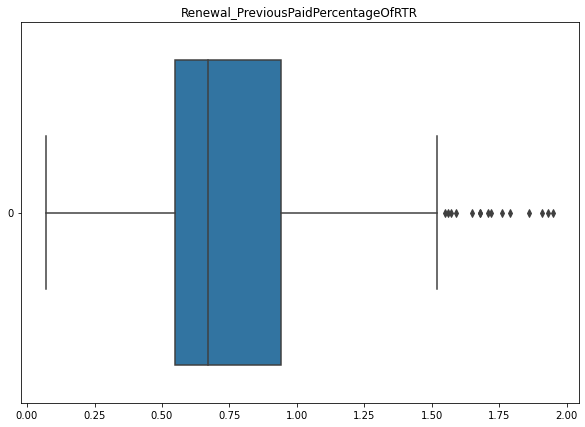

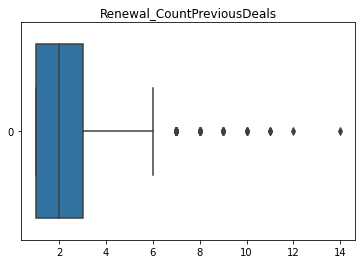

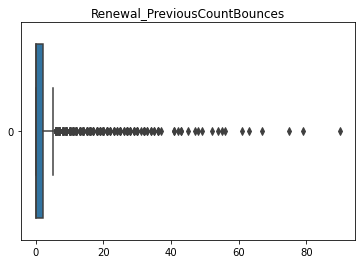

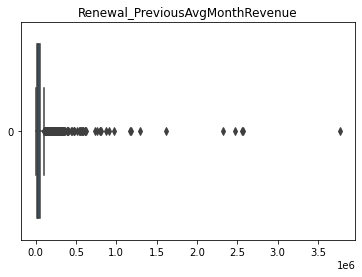

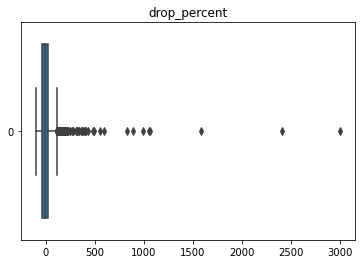

In [20]:
# Box plot check to find major outliers on renewal data
f,ax=plt.subplots(figsize=(10,7))
for i in data.columns[7:12]:
    plt.clf() #clearing the figure
    sns.boxplot(data=data[i], orient='h')
    plt.title(i)
    plt.show()

In [21]:
# Only one outlier has been treated which is a dollar attribute and other renewal outliers have not been treated
# based on the discussion with Saleem
var_with_out = ['Renewal_PreviousAvgMonthRevenue']

In [22]:
# Outlier imputation (not removal due to less data points) has been done based on the understanding of boxplots
min_value,max_value,q25_value,q75_value = [],[],[],[]
for i in var_with_out:
    q25 = data.loc[:,i].quantile(.25)
    q75 = data.loc[:,i].quantile(.75)
    iqr = q75 - q25
    minn = q25 - (iqr*1.5)
    maxx = q75 + (iqr*1.5)
    # These lists of values will  be used for outlier treatment in the validation set
    min_value.append(minn)
    max_value.append(maxx)
    q25_value.append(q25)
    q75_value.append(q75)
    
    print(i,minn,maxx,q25,q75,iqr)
    
    
    data.loc[data.loc[:,i]<minn,i]=q25#data.loc[:,i].median()
    data.loc[data.loc[:,i]>maxx,i]=q75#data.loc[:,i].median()

Renewal_PreviousAvgMonthRevenue -41829.89875000001 108144.49125 14410.497500000001 51904.095 37493.5975


In [23]:
print(min_value)
print(max_value)
print(q25_value)
print(q75_value)

[-41829.89875000001]
[108144.49125]
[14410.497500000001]
[51904.095]


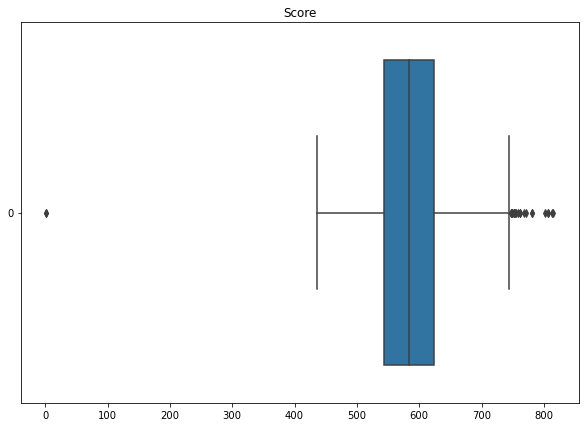

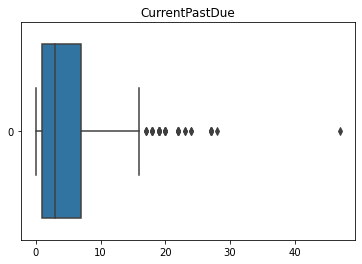

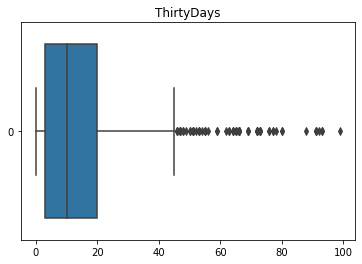

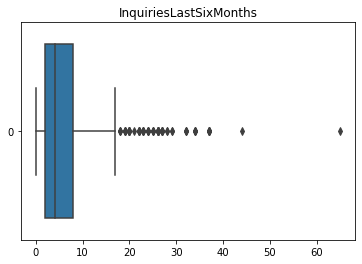

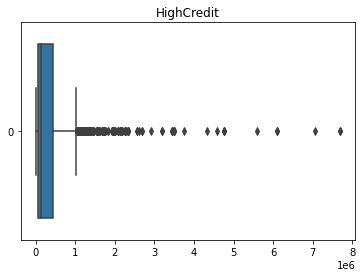

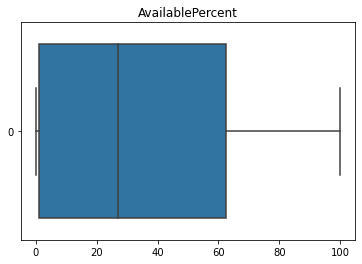

In [24]:
# Box plot check to find major outliers on CBC data
f,ax=plt.subplots(figsize=(10,7))
for i in data.columns[-6:]:
    plt.clf() #clearing the figure
    sns.boxplot(data=data[i], orient='h')
    plt.title(i)
    plt.show()

<AxesSubplot:xlabel='Score', ylabel='Density'>

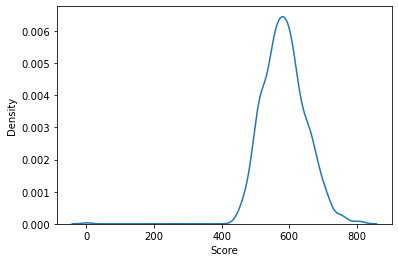

In [25]:
# Observation: Some Score values are 1 and need to be treated
sns.kdeplot(data['Score'])

In [26]:
data[data['Score'] < 100][['Score','WriteOff_YN']]

,Score,WriteOff_YN
589,1.0,1.0
1759,1.0,1.0


In [27]:
median_score = data['Score'].median()
median_score

583.0

In [28]:
# We are replacing values of score=1 with median values due to better results using median imputation
# Other imputations like mean, lower quartile values were also tried
data['Score'] = data['Score'].replace(1,median_score)
data[data['Score'] < 400]['Score']

Series([], Name: Score, dtype: float64)

<AxesSubplot:xlabel='Score', ylabel='Density'>

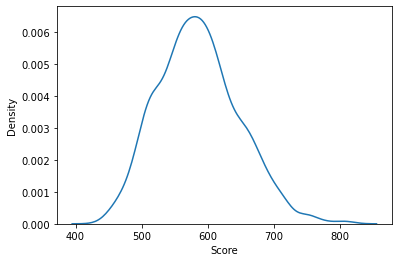

In [29]:
# Distribution after outlier imputation
sns.kdeplot(data['Score'])

<AxesSubplot:xlabel='HighCredit', ylabel='Density'>

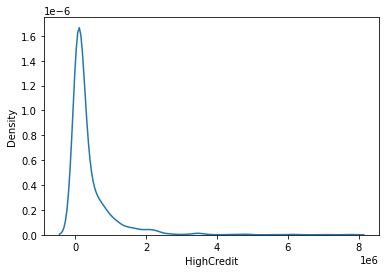

In [30]:
# Distribution before outlier imputation
sns.kdeplot(data['HighCredit'])

C:\Users\Siddhant\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='HighCredit'>

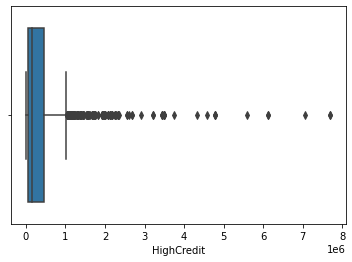

In [31]:
sns.boxplot(data['HighCredit'])

In [32]:
median_high_credit = data['HighCredit'].median()
median_high_credit

142139.0

In [33]:
# As per the discussions with Saleem, values greater than 3000000 were imputed with median
data['HighCredit'] = data['HighCredit'].apply(lambda x:x if x < 3000000 else median_high_credit)

<AxesSubplot:xlabel='HighCredit', ylabel='Density'>

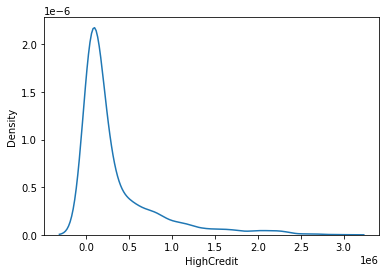

In [34]:
# Distribution after outlier imputation
sns.kdeplot(data['HighCredit'])

## Step-2 - Missing Values Treatment

In [35]:
data.isnull().sum().sort_values(ascending = False)/len(data)*100

Renewal_PreviousAvgMonthRevenue        2.539168
Renewal_PreviousPaidPercentageOfRTR    0.324149
drop_percent                           0.054025
OpportunityID                          0.000000
firmreportedsalesrange                 0.000000
HighCredit                             0.000000
InquiriesLastSixMonths                 0.000000
ThirtyDays                             0.000000
CurrentPastDue                         0.000000
Score                                  0.000000
sosincorporationtimeoldest             0.000000
lienothercount                         0.000000
lientimeoldest                         0.000000
inquiryconsumerphone                   0.000000
inquirycreditcount03m                  0.000000
b2bactvfltworstperfindx                0.000000
firmemployeerangecount                 0.000000
FundedDate                             0.000000
b2bactvfltcntgrow1y                    0.000000
Drop_category                          0.000000
Renewal_PreviousCountBounces           0

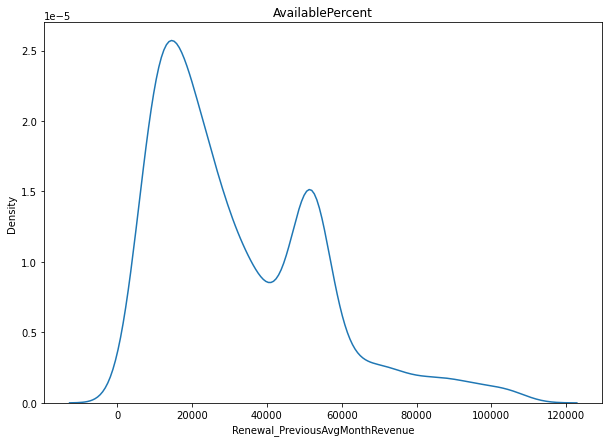

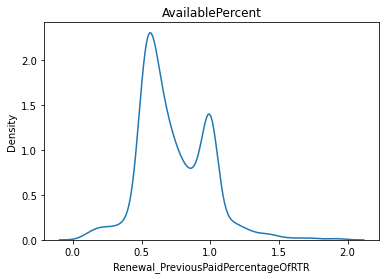

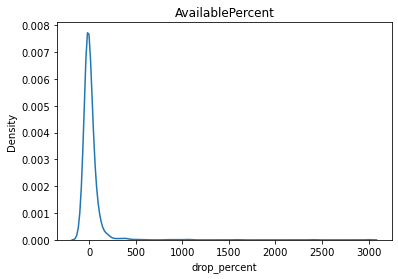

In [36]:
f,ax=plt.subplots(figsize=(10,7))
for col in ['Renewal_PreviousAvgMonthRevenue','Renewal_PreviousPaidPercentageOfRTR','drop_percent']:
    plt.clf() #clearing the figure
    sns.kdeplot(data=data[col])
    plt.title(i)
    plt.show()

In [37]:
Renewal_PreviousAvgMonthRevenue_median = data['Renewal_PreviousAvgMonthRevenue'].median()
Renewal_PreviousPaidPercentageOfRTR_median = data['Renewal_PreviousPaidPercentageOfRTR'].median()
drop_percent_median = data['drop_percent'].median()

In [38]:
# Imputing these missing values with median due to skewness in the distribution
data['Renewal_PreviousAvgMonthRevenue'].fillna(Renewal_PreviousAvgMonthRevenue_median,inplace = True)
data['Renewal_PreviousPaidPercentageOfRTR'].fillna(Renewal_PreviousPaidPercentageOfRTR_median,inplace = True)
data['drop_percent'].fillna(drop_percent_median,inplace = True)

## Step 3- Feature Engineering

In [39]:
data['b2bactvfltcntgrow1y'].value_counts()

-99998.0    1540
-99999.0     264
 1.0          27
 0.0          12
 2.0           4
 0.5           4
Name: b2bactvfltcntgrow1y, dtype: int64

In [40]:
data['b2bactvfltworstperfindx'].value_counts()

-99998.0    1469
-99999.0     264
 0.0          64
 1.0          15
 3.0          15
 4.0          15
 2.0           9
Name: b2bactvfltworstperfindx, dtype: int64

In [41]:
for i in ['b2bactvfltcntgrow1y','b2bactvfltworstperfindx']:
    data[i+'_value'] = data[i].apply(lambda x:0 if x < 0 else x)
    data[i+'_flag'] = data[i].apply(lambda x: 1 if x < 0 else 0)
    data.drop(i,axis = 'columns',inplace = True)

In [42]:
data[['b2bactvfltcntgrow1y_flag','b2bactvfltcntgrow1y_value','b2bactvfltworstperfindx_flag','b2bactvfltworstperfindx_value']]

,b2bactvfltcntgrow1y_flag,b2bactvfltcntgrow1y_value,b2bactvfltworstperfindx_flag,b2bactvfltworstperfindx_value
1488,1,0.0,1,0.0
1604,1,0.0,0,1.0
1199,1,0.0,1,0.0
409,1,0.0,1,0.0
1671,1,0.0,1,0.0
...,...,...,...,...
1871,1,0.0,1,0.0
1250,1,0.0,1,0.0
1288,1,0.0,1,0.0
1473,1,0.0,1,0.0


In [43]:
# Checking the original attribute values
data[['firmemployeerangecount','firmreportedsalesrange']]

,firmemployeerangecount,firmreportedsalesrange
1488,-1.0,-1.0
1604,-1.0,-1.0
1199,-1.0,-1.0
409,20.0,50.0
1671,20.0,0.0
...,...,...
1871,10.0,30.0
1250,-1.0,-1.0
1288,40.0,70.0
1473,20.0,60.0


In [44]:
data['firmemployeerangecount'].value_counts()

-1.0     855
 20.0    346
 10.0    195
 30.0    172
 40.0    128
 0.0      94
 50.0     51
 60.0     10
Name: firmemployeerangecount, dtype: int64

In [45]:
# Applying one hot encoding
data = pd.get_dummies(data,columns = ['firmemployeerangecount','firmreportedsalesrange'])

In [46]:
# Observing raw 'inquirycreditcount03m' attribute
data['inquirycreditcount03m'].value_counts()

 0.0     1221
-1.0      264
 1.0      185
 2.0      112
 3.0       25
 4.0       23
 6.0        8
 5.0        6
 8.0        1
 14.0       1
 11.0       1
 12.0       1
 9.0        1
 7.0        1
 16.0       1
Name: inquirycreditcount03m, dtype: int64

In [47]:
# breaking this numerical attribute into flag and values
for i in ['inquirycreditcount03m']:
    data[i+'_value'] = data[i].apply(lambda x:0 if x < 0 else x)
    data[i+'_flag'] = data[i].apply(lambda x: 1 if x < 0 else 0)
    data.drop(i,axis = 'columns',inplace = True)

In [48]:
data['inquiryconsumerphone'].value_counts()

 1.0    922
 0.0    709
-1.0    220
Name: inquiryconsumerphone, dtype: int64

In [49]:
for i in ['inquiryconsumerphone']:
    data[i+'_f1'] = data[i].apply(lambda x: 1 if x == -1 else 0)
    data[i+'_f2'] = data[i].apply(lambda x: 1 if x == 0 else 0)
    data[i+'_f3'] = data[i].apply(lambda x: 1 if x == 1 else 0)
    data.drop(i,axis = 'columns',inplace = True)

In [50]:
data['lientimeoldest'].value_counts()

 0.0     1283
-1.0      264
 83.0      11
 80.0      10
 23.0       7
         ... 
 61.0       1
 47.0       1
 66.0       1
 67.0       1
 63.0       1
Name: lientimeoldest, Length: 85, dtype: int64

In [51]:
data['lienothercount'].value_counts()

 0.0    1557
-1.0     264
 1.0      14
 3.0       6
 2.0       3
 6.0       3
 5.0       2
 4.0       1
 8.0       1
Name: lienothercount, dtype: int64

In [52]:
# These are treated as continuous values except when they are less than 0, a flag is assigned to them
for i in ['lientimeoldest','lienothercount']:
    data[i+'_value'] = data[i].apply(lambda x:0 if x < 0 else x)
    data[i+'_flag'] = data[i].apply(lambda x: 1 if x < 0 else 0)
    data.drop(i,axis = 'columns',inplace = True)

In [53]:
data['sosincorporationtimeoldest'].value_counts()

-1.0      729
 17.0      23
 16.0      22
 10.0      22
 18.0      20
         ... 
 155.0      1
 163.0      1
 146.0      1
 814.0      1
 365.0      1
Name: sosincorporationtimeoldest, Length: 280, dtype: int64

In [54]:
for i in ['sosincorporationtimeoldest']:     
    data[i+'_value'] = data[i].apply(lambda x: 0 if x < 0 else x)
    data[i+'_flag'] = data[i].apply(lambda x: 1 if x < 0 else 0)
    data.drop(i,axis = 'columns',inplace = True)

In [55]:
data = pd.get_dummies(data,columns = ['Drop_category'])

In [56]:
# Final DataFrame after EDA and feature engineering
data

,OpportunityID,FundedDate,WriteOff_YN,FundedAmount,Paybackamount,FundedWriteOffAmount_Gross,WOGross_AdvanceBalance,Renewal_PreviousPaidPercentageOfRTR,Renewal_CountPreviousDeals,Renewal_PreviousCountBounces,...,inquiryconsumerphone_f3,lientimeoldest_value,lientimeoldest_flag,lienothercount_value,lienothercount_flag,sosincorporationtimeoldest_value,sosincorporationtimeoldest_flag,Drop_category_Negative,Drop_category_Neutral/Null,Drop_category_Positive
1488,0062M00000nXcg6QAC,2021-10-01,0.0,10000.0,14900.00,0.00,0.00,1.00,1.0,1.0,...,0,0.0,0,0.0,0,0.0,1,1,0,0
1604,0062M00000jL1CZQA0,2020-03-09,1.0,5500.0,8195.00,4964.00,7659.00,0.84,1.0,4.0,...,1,0.0,0,0.0,0,33.0,0,1,0,0
1199,0062M00000nWHmIQAW,2021-09-07,0.0,7000.0,10430.00,0.00,0.00,0.52,5.0,0.0,...,0,0.0,0,0.0,0,45.0,0,1,0,0
409,0062M00000o9pjzQAA,2022-01-31,0.0,14037.0,20915.13,0.00,0.00,0.07,3.0,0.0,...,0,0.0,0,0.0,0,10.0,0,1,0,0
1671,0062M00000n1wZYQAY,2021-06-28,0.0,30000.0,44700.00,0.00,0.00,0.69,2.0,0.0,...,1,24.0,0,0.0,0,0.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871,0062M00000o8KPLQA2,2022-01-05,1.0,8000.0,11920.00,0.00,3136.39,0.57,1.0,0.0,...,0,0.0,0,0.0,0,15.0,0,0,0,1
1250,0062M00000mTTtXQAW,2021-08-10,0.0,7000.0,10430.00,0.00,0.00,1.37,3.0,7.0,...,1,0.0,1,0.0,1,0.0,1,1,0,0
1288,0062M00000jxrOCQAY,2020-06-03,0.0,30000.0,44700.00,0.00,0.00,1.00,1.0,0.0,...,0,0.0,0,0.0,0,228.0,0,1,0,0
1473,0062M00000nWafwQAC,2021-09-09,1.0,12000.0,17880.00,0.00,2384.00,0.73,3.0,5.0,...,1,0.0,0,0.0,0,0.0,1,0,0,1


## Step 4- Model Training

In [57]:
X_train = data.drop(columns = ['WriteOff_YN'],axis=1)
y_train = data['WriteOff_YN']

In [58]:
print(X_train.shape,y_train.shape)

(1851, 56) (1851,)


In [59]:
# As per case3 these are the 21 attributes which are part of the model training process
cols = [
              'Renewal_PreviousPaidPercentageOfRTR',
              'Renewal_CountPreviousDeals',
              'Renewal_PreviousCountBounces',
              'Renewal_PreviousAvgMonthRevenue',
              'drop_percent',
              'Drop_category_Positive',
              'b2bactvfltcntgrow1y_value',
              'b2bactvfltworstperfindx_value',
              'firmemployeerangecount_60.0',
              'firmreportedsalesrange_40.0',
              'inquirycreditcount03m_value',
              'inquiryconsumerphone_f2',
              'lientimeoldest_value',
              'lienothercount_value',
              'sosincorporationtimeoldest_value',
              'Score',
              'CurrentPastDue',
              'ThirtyDays',
              'InquiriesLastSixMonths',
              'HighCredit',
              'AvailablePercent'
]
len(cols)

21

In [60]:
import statsmodels.api as sm

In [61]:
X_train_with_constant = sm.add_constant(X_train[cols],has_constant='add')

In [62]:
print(X_train[cols].shape)
print(X_train_with_constant.shape)

(1851, 21)
(1851, 22)


In [63]:
# building the model and fitting the data
logit_model= sm.Logit(y_train, X_train_with_constant).fit()

Optimization terminated successfully.
         Current function value: 0.500410
         Iterations 7


In [64]:
# printing the summary table
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WriteOff_YN   No. Observations:                 1851
Model:                          Logit   Df Residuals:                     1829
Method:                           MLE   Df Model:                           21
Date:                Tue, 31 Jan 2023   Pseudo R-squ.:                 0.08964
Time:                        12:45:07   Log-Likelihood:                -926.26
converged:                       True   LL-Null:                       -1017.5
Covariance Type:            nonrobust   LLR p-value:                 1.011e-27
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   1.3974      0.814      1.717      0.086      -0.198       2.993
Renewal_PreviousPaidPercentageOfRTR    -0.9081      0.249     -3.651      0.000      -1.396      -0.421
Renewal_CountPreviousDeals             -0.0449      0.036     -1.265      0.206      -0.115       0.025
Renewal_PreviousCountBounces            0.0175      0.007      2.367      0.018       0.003       0.032
Renewal_PreviousAvgMonthRevenue      1.066e-05   2.77e-06      3.855      0.000    5.24e-06    1.61e-05
drop_percent                            0.0024      0.001      3.225      0.001       0.001       0.004
Drop_category_Positive                  0.2700      0.135      1.993      0.046       0.005       0.536
b2bactvfltcntgrow1y_value              -1.8236      0.683     -2.669      0.008      -3.163      -0.484
b2bactvfltworstperfindx_value           0.3957      0.121      3.258      0.001       0.158       0.634
firmemployeerangecount_60.0             1.5171      0.689      2.201      0.028       0.166       2.868
firmreportedsalesrange_40.0            -0.4791      0.336     -1.428      0.153      -1.137       0.179
inquirycreditcount03m_value             0.0935      0.049      1.911      0.056      -0.002       0.189
inquiryconsumerphone_f2                -0.3047      0.125     -2.440      0.015      -0.549      -0.060
lientimeoldest_value                   -0.0123      0.005     -2.701      0.007      -0.021      -0.003
lienothercount_value                    0.3758      0.141      2.663      0.008       0.099       0.652
sosincorporationtimeoldest_value       -0.0019      0.001     -2.116      0.034      -0.004      -0.000
Score                                  -0.0039      0.001     -2.951      0.003      -0.006      -0.001
CurrentPastDue                          0.0264      0.014      1.833      0.067      -0.002       0.055
ThirtyDays                             -0.0128      0.005     -2.587      0.010      -0.023      -0.003
InquiriesLastSixMonths                  0.0166      0.009      1.759      0.079      -0.002       0.035
HighCredit                          -3.615e-07   1.58e-07     -2.283      0.022   -6.72e-07   -5.11e-08
AvailablePercent                        0.0048      0.002      2.718      0.007       0.001       0.008
=======================================================================================================
"""

In [100]:
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"P>|z|":pvals,
                               "coef":coeff,
                               "co":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df

In [101]:
results_summary_to_dataframe(logit_model)

,coeff,pvals,conf_lower,conf_higher
const,1.397432e+00,0.086031,-1.980045e-01,2.992868e+00
Renewal_PreviousPaidPercentageOfRTR,-9.080899e-01,0.000261,-1.395586e+00,-4.205938e-01
Renewal_CountPreviousDeals,-4.493657e-02,0.205858,-1.145583e-01,2.468512e-02
Renewal_PreviousCountBounces,1.747297e-02,0.017937,3.004218e-03,3.194173e-02
Renewal_PreviousAvgMonthRevenue,1.066465e-05,0.000116,5.242537e-06,1.608677e-05
drop_percent,2.428554e-03,0.001259,9.526846e-04,3.904424e-03
Drop_category_Positive,2.700281e-01,0.046214,4.533349e-03,5.355228e-01
b2bactvfltcntgrow1y_value,-1.823601e+00,0.007613,-3.162867e+00,-4.843349e-01
b2bactvfltworstperfindx_value,3.957219e-01,0.001124,1.576274e-01,6.338163e-01
firmemployeerangecount_60.0,1.517108e+00,0.027752,1.660000e-01,2.868215e+00


In [65]:
# Logit train data prediction 
logit_pred_train=pd.DataFrame(logit_model.predict(X_train_with_constant),columns=["pred_1"])
logit_pred_train=pd.concat([X_train_with_constant,X_train[['WOGross_AdvanceBalance', 'FundedAmount',
       'FundedWriteOffAmount_Gross','Paybackamount','OpportunityID','FundedDate']],y_train,logit_pred_train],axis=1)
logit_pred_train["y_pred"]=list(map(round,logit_model.predict(X_train_with_constant)))

## Step 5 - Decile and Pentile Chart

In [66]:
#--LOGIT Train data
train_decile = ks(data=logit_pred_train,target="WriteOff_YN", prob="pred_1")
train_decile = train_decile[['No_of_Opps','No_of_WOs','%_Unit_WO_Rate','min_prob', 'max_prob', 'Avg_score', 
        'cum_Unit_WO', 'Funded_$', '%_Funded_$',
       'Funded_WO_Gross_$', 'Gross_$_rate', 'Cum_Gross_WO_$',
       'WO_Gross_Advance_Balance', 'PaybackAmount_$', 'Gross_Advance_Rate']]
train_decile

,No_of_Opps,No_of_WOs,%_Unit_WO_Rate,min_prob,max_prob,Avg_score,cum_Unit_WO,Funded_$,%_Funded_$,Funded_WO_Gross_$,Gross_$_rate,Cum_Gross_WO_$,WO_Gross_Advance_Balance,PaybackAmount_$,Gross_Advance_Rate
Decile,,,,,,,,,,,,,,,
1,186,12.0,6.45,1.20,8.61,4.90,2.70,7302000.0,17.23,58022.08,0.79,1.45,119092.77,10609590.00,1.12
2,185,23.0,12.43,8.62,12.76,10.69,7.90,6288740.0,14.84,458280.34,7.29,12.90,934991.05,9196308.60,10.17
3,185,22.0,11.89,12.77,15.91,14.34,12.88,4748750.0,11.20,427047.60,8.99,23.57,975059.76,6949117.50,14.03
4,185,26.0,14.05,15.92,18.91,17.42,18.76,4009100.0,9.46,208654.78,5.20,28.78,456355.92,5852364.00,7.80
5,185,41.0,22.16,18.92,21.77,20.34,28.04,2863725.0,6.76,206272.74,7.20,33.93,503261.76,4229020.25,11.90
6,185,45.0,24.32,21.79,24.94,23.36,38.22,2729559.0,6.44,281197.85,10.30,40.96,581467.75,4047492.91,14.37
7,185,54.0,29.19,24.94,28.67,26.80,50.44,3280650.0,7.74,272940.16,8.32,47.78,794121.97,4827898.50,16.45
8,185,52.0,28.11,28.67,33.48,31.08,62.21,3044700.0,7.18,385860.89,12.67,57.42,835213.10,4519115.00,18.48
9,185,71.0,38.38,33.52,41.03,37.28,78.28,3329542.0,7.85,435000.58,13.06,68.29,942096.13,4928933.38,19.11


In [67]:
#--LOGIT Train data
train_pentile = ksp(data=logit_pred_train,target="WriteOff_YN", prob="pred_1")
train_pentile = train_pentile[['No_of_Opps','No_of_WOs','%_Unit_WO_Rate','min_prob', 'max_prob', 'Avg_score', 
        'cum_Unit_WO', 'Funded_$', '%_Funded_$',
       'Funded_WO_Gross_$', 'Gross_$_rate', 'Cum_Gross_WO_$',
       'WO_Gross_Advance_Balance', 'PaybackAmount_$', 'Gross_Advance_Rate']]
train_pentile

,No_of_Opps,No_of_WOs,%_Unit_WO_Rate,min_prob,max_prob,Avg_score,cum_Unit_WO,Funded_$,%_Funded_$,Funded_WO_Gross_$,Gross_$_rate,Cum_Gross_WO_$,WO_Gross_Advance_Balance,PaybackAmount_$,Gross_Advance_Rate
Pentile,,,,,,,,,,,,,,,
1,371,35.0,9.43,1.20,12.76,6.98,7.90,13590740.0,32.06,516302.42,3.80,12.90,1054083.82,19805898.60,5.32
2,370,48.0,12.97,12.77,18.91,15.84,18.76,8757850.0,20.66,635702.38,7.26,28.78,1431415.68,12801481.50,11.18
3,370,86.0,23.24,18.92,24.94,21.93,38.21,5593284.0,13.19,487470.59,8.72,40.96,1084729.51,8276513.16,13.11
4,370,106.0,28.65,24.94,33.48,29.21,62.20,6325350.0,14.92,658801.05,10.42,57.42,1629335.07,9347013.50,17.43
5,370,167.0,45.14,33.52,99.79,66.66,100.00,8122679.0,19.16,1704344.68,20.98,100.00,3508497.15,12106777.51,28.98


In [68]:
# This can be exported as a csv file to analyse each OpportunityID along with its rank 
logit_pred_train

,const,Renewal_PreviousPaidPercentageOfRTR,Renewal_CountPreviousDeals,Renewal_PreviousCountBounces,Renewal_PreviousAvgMonthRevenue,drop_percent,Drop_category_Positive,...,WriteOff_YN,pred_1,y_pred,target0,Rank,Decile,Pentile
1488,1.0,1.00,1.0,1.0,51904.095,-41.441111,0,...,0.0,0.178454,0,1.0,662.0,4,2
1604,1.0,0.84,1.0,4.0,25226.340,-51.165954,0,...,1.0,0.337049,0,0.0,1487.0,9,5
1199,1.0,0.52,5.0,0.0,16808.380,-5.692905,0,...,0.0,0.166921,0,1.0,598.0,4,2
409,1.0,0.07,3.0,0.0,105452.140,-1.008839,0,...,0.0,0.519931,1,1.0,1784.0,10,5
1671,1.0,0.69,2.0,0.0,70634.900,26.900247,1,...,0.0,0.259495,0,1.0,1161.0,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871,1.0,0.57,1.0,0.0,30066.300,36.381387,1,...,1.0,0.339540,0,0.0,1496.0,9,5
1250,1.0,1.37,3.0,7.0,15934.810,-46.270827,0,...,0.0,0.119482,0,1.0,325.0,2,1
1288,1.0,1.00,1.0,0.0,100720.500,-14.795978,0,...,0.0,0.155669,0,1.0,528.0,3,2
1473,1.0,0.73,3.0,5.0,53010.530,319.168498,1,...,1.0,0.532542,1,0.0,1791.0,10,5


# Analysis and preparation of Validation Dataset

## Step1 - Outlier Treatment

In [69]:
# These are the values from training set to be used for outlier treatment in the validation set for renewal attributes
print(var_with_out)
print(min_value)
print(max_value)
print(q25_value)
print(q75_value)

['Renewal_PreviousAvgMonthRevenue']
[-41829.89875000001]
[108144.49125]
[14410.497500000001]
[51904.095]


In [70]:
# Outlier treatment in the validation set for renewal attributes
for i in range(len(var_with_out)):
    valid_df.loc[valid_df.loc[:,var_with_out[i]]< min_value[i],var_with_out[i]]=q25_value[i]
    valid_df.loc[valid_df.loc[:,var_with_out[i]]>max_value[i],var_with_out[i]]=q75_value[i]

In [71]:
valid_df['Renewal_PreviousAvgMonthRevenue'].describe()

count       776.000000
mean      31817.327945
std       21685.157909
min         122.020000
25%       14365.462500
50%       24447.835000
75%       49575.727500
max      107850.280000
Name: Renewal_PreviousAvgMonthRevenue, dtype: float64

In [72]:
# Checking the outliers in Score attribute
valid_df[valid_df['Score'] < 400][['Score','WriteOff_YN']]

,Score,WriteOff_YN
290,0.0,0.0
508,0.0,0.0
710,1.0,0.0
715,1.0,0.0
932,0.0,0.0
1300,1.0,0.0
1646,0.0,0.0
1825,1.0,1.0
2053,1.0,0.0
2225,0.0,0.0


In [73]:
# Replacing Score=0,1 with value used for replacement in the training set
valid_df['Score'] = valid_df['Score'].replace(1,median_score)
valid_df['Score'] = valid_df['Score'].replace(0,median_score)
valid_df[valid_df['Score'] < 400]['Score']

Series([], Name: Score, dtype: float64)

In [74]:
valid_df[valid_df['HighCredit'] > 3000000]['HighCredit']

1988    3491440.0
601     7695770.0
682     9434234.0
1480    3295691.0
1517    3204294.0
Name: HighCredit, dtype: float64

In [75]:
# Treating the outliers in HighCredit attribute whose values are greater than 3000000
valid_df['HighCredit'] = valid_df['HighCredit'].apply(lambda x:x if x < 3000000 else median_high_credit)

## Step 2 - Missing Values 

In [76]:
# Checking for missing values in the validation set
valid_df.isnull().sum().sort_values(ascending = True)/len(valid_df)*100

OpportunityID                          0.000000
InquiriesLastSixMonths                 0.000000
ThirtyDays                             0.000000
CurrentPastDue                         0.000000
Score                                  0.000000
sosincorporationtimeoldest             0.000000
lienothercount                         0.000000
lientimeoldest                         0.000000
inquiryconsumerphone                   0.000000
inquirycreditcount03m                  0.000000
firmreportedsalesrange                 0.000000
firmemployeerangecount                 0.000000
b2bactvfltworstperfindx                0.000000
b2bactvfltcntgrow1y                    0.000000
Drop_category                          0.000000
Renewal_PreviousCountBounces           0.000000
Renewal_CountPreviousDeals             0.000000
WOGross_AdvanceBalance                 0.000000
FundedWriteOffAmount_Gross             0.000000
Paybackamount                          0.000000
FundedAmount                           0

In [77]:
# Imputing missing values with the values used to make imputauions in the training set
valid_df['Renewal_PreviousAvgMonthRevenue'].fillna(Renewal_PreviousAvgMonthRevenue_median,inplace = True)
valid_df['Renewal_PreviousPaidPercentageOfRTR'].fillna(Renewal_PreviousPaidPercentageOfRTR_median,inplace = True)
valid_df['drop_percent'].fillna(drop_percent_median,inplace = True)

In [78]:
valid_df.isnull().sum().sort_values(ascending = True)/len(valid_df)*100

OpportunityID                          0.0
InquiriesLastSixMonths                 0.0
ThirtyDays                             0.0
CurrentPastDue                         0.0
Score                                  0.0
sosincorporationtimeoldest             0.0
lienothercount                         0.0
lientimeoldest                         0.0
inquiryconsumerphone                   0.0
inquirycreditcount03m                  0.0
firmreportedsalesrange                 0.0
firmemployeerangecount                 0.0
b2bactvfltworstperfindx                0.0
b2bactvfltcntgrow1y                    0.0
Drop_category                          0.0
drop_percent                           0.0
Renewal_PreviousAvgMonthRevenue        0.0
Renewal_PreviousCountBounces           0.0
Renewal_CountPreviousDeals             0.0
Renewal_PreviousPaidPercentageOfRTR    0.0
WOGross_AdvanceBalance                 0.0
FundedWriteOffAmount_Gross             0.0
Paybackamount                          0.0
FundedAmoun

## Step 3 - Feature Engineering

In [79]:
for i in ['b2bactvfltcntgrow1y','b2bactvfltworstperfindx']:
    valid_df[i+'_value'] = valid_df[i].apply(lambda x:0 if x < 0 else x)
    valid_df[i+'_flag'] = valid_df[i].apply(lambda x: 1 if x < 0 else 0)
    valid_df.drop(i,axis = 'columns',inplace = True)

In [80]:
valid_df = pd.get_dummies(valid_df,columns = ['firmemployeerangecount','firmreportedsalesrange'])

In [81]:
for i in ['inquirycreditcount03m']:
    valid_df[i+'_value'] = valid_df[i].apply(lambda x:0 if x < 0 else x)
    valid_df[i+'_flag'] = valid_df[i].apply(lambda x: 1 if x < 0 else 0)
    valid_df.drop(i,axis = 'columns',inplace = True)

In [82]:
for i in ['inquiryconsumerphone']:
    valid_df[i+'_f1'] = valid_df[i].apply(lambda x: 1 if x == -1 else 0)
    valid_df[i+'_f2'] = valid_df[i].apply(lambda x: 1 if x == 0 else 0)
    valid_df[i+'_f3'] = valid_df[i].apply(lambda x: 1 if x == 1 else 0)
    valid_df.drop(i,axis = 'columns',inplace = True)

In [83]:
for i in ['lientimeoldest','lienothercount']:
    valid_df[i+'_value'] = valid_df[i].apply(lambda x:0 if x < 0 else x)
    valid_df[i+'_flag'] = valid_df[i].apply(lambda x: 1 if x < 0 else 0)
    valid_df.drop(i,axis = 'columns',inplace = True)

In [84]:
for i in ['sosincorporationtimeoldest']:     
    valid_df[i+'_value'] = valid_df[i].apply(lambda x: 0 if x < 0 else x)
    valid_df[i+'_flag'] = valid_df[i].apply(lambda x: 1 if x < 0 else 0)
    valid_df.drop(i,axis = 'columns',inplace = True)

In [85]:
valid_df = pd.get_dummies(valid_df,columns = ['Drop_category'])

In [86]:
valid_df.shape

(789, 58)

## Step 4 - Analysing Validation Datapoints based on the model training

In [87]:
X_valid=valid_df.drop('WriteOff_YN',axis=1)
y_valid=valid_df['WriteOff_YN']

In [88]:
X_valid_with_constant = sm.add_constant(X_valid[cols],has_constant='add')

In [89]:
X_valid_with_constant.head()

,const,Renewal_PreviousPaidPercentageOfRTR,Renewal_CountPreviousDeals,Renewal_PreviousCountBounces,Renewal_PreviousAvgMonthRevenue,drop_percent,Drop_category_Positive,...,sosincorporationtimeoldest_value,Score,CurrentPastDue,ThirtyDays,InquiriesLastSixMonths,HighCredit,AvailablePercent
1880,1.0,1.53,2.0,36.0,43802.25,-0.731969,0,...,110.0,558.0,5.0,67.0,3.0,370430.0,12.0
1768,1.0,0.63,1.0,1.0,17684.34,-6.211574,0,...,38.0,469.0,6.0,10.0,13.0,18572.0,0.0
918,1.0,0.57,4.0,0.0,30016.29,-33.252912,0,...,0.0,591.0,5.0,26.0,2.0,125233.0,23.0
49,1.0,1.00,2.0,1.0,30459.94,-14.153969,0,...,21.0,604.0,1.0,15.0,4.0,317950.0,6.0
1906,1.0,1.45,1.0,8.0,10237.09,38.534303,1,...,55.0,600.0,9.0,13.0,9.0,97875.0,64.0


In [90]:
#Logit valid data prediction
logit_pred_valid=pd.DataFrame(logit_model.predict(X_valid_with_constant),columns=["pred_1"])
logit_pred_valid=pd.concat([X_valid_with_constant,X_valid[['WOGross_AdvanceBalance', 'FundedAmount',
       'FundedWriteOffAmount_Gross','Paybackamount','OpportunityID','FundedDate']],y_valid,logit_pred_valid],axis=1)
logit_pred_valid["y_pred"]=list(map(round,logit_model.predict(X_valid_with_constant)))

## Step 5 - Decile and Pentile Charts

In [91]:
#--LOGIT Valid data
validation_decile = ks(data=logit_pred_valid,target="WriteOff_YN", prob="pred_1")
validation_decile = validation_decile[['No_of_Opps','No_of_WOs','%_Unit_WO_Rate','min_prob', 'max_prob', 'Avg_score', 
        'cum_Unit_WO', 'Funded_$', '%_Funded_$',
       'Funded_WO_Gross_$', 'Gross_$_rate', 'Cum_Gross_WO_$',
       'WO_Gross_Advance_Balance', 'PaybackAmount_$', 'Gross_Advance_Rate']]
validation_decile

,No_of_Opps,No_of_WOs,%_Unit_WO_Rate,min_prob,max_prob,Avg_score,cum_Unit_WO,Funded_$,%_Funded_$,Funded_WO_Gross_$,Gross_$_rate,Cum_Gross_WO_$,WO_Gross_Advance_Balance,PaybackAmount_$,Gross_Advance_Rate
Decile,,,,,,,,,,,,,,,
1,79,4.0,5.06,1.31,8.15,4.73,2.14,2010957.79,11.16,30261.85,1.50,1.52,58001.85,2928837.11,1.98
2,79,9.0,11.39,8.41,12.26,10.34,6.97,2539609.00,14.09,224433.42,8.84,12.76,503163.42,3705984.33,13.58
3,79,7.0,8.86,12.30,15.42,13.86,10.72,2989200.00,16.58,185299.47,6.20,22.05,409598.67,4365908.00,9.38
4,79,14.0,17.72,15.51,18.48,17.00,18.23,1947078.00,10.80,52705.22,2.71,24.69,126939.22,2845556.22,4.46
5,79,22.0,27.85,18.49,21.22,19.85,30.03,1403334.00,7.79,201038.46,14.33,34.76,369113.72,2078297.66,17.76
6,79,17.0,21.52,21.31,24.66,22.98,39.15,1172850.00,6.51,106112.63,9.05,40.08,193007.63,1732306.50,11.14
7,79,23.0,29.11,24.71,27.33,26.02,51.49,1505690.00,8.35,294693.23,19.57,54.85,493590.00,2207156.10,22.36
8,79,26.0,32.91,27.33,31.89,29.61,65.43,1064000.00,5.90,117384.03,11.03,60.73,294102.58,1583890.00,18.57
9,79,29.0,36.71,31.91,39.45,35.68,80.99,1613500.00,8.95,240241.12,14.89,72.77,450307.31,2339615.00,19.25


In [92]:
#--LOGIT Valid data
validation_pentile = ksp(data=logit_pred_valid,target="WriteOff_YN", prob="pred_1")
validation_pentile = validation_pentile[['No_of_Opps','No_of_WOs','%_Unit_WO_Rate','min_prob', 'max_prob', 'Avg_score', 
        'cum_Unit_WO', 'Funded_$', '%_Funded_$',
       'Funded_WO_Gross_$', 'Gross_$_rate', 'Cum_Gross_WO_$',
       'WO_Gross_Advance_Balance', 'PaybackAmount_$', 'Gross_Advance_Rate']]
validation_pentile

,No_of_Opps,No_of_WOs,%_Unit_WO_Rate,min_prob,max_prob,Avg_score,cum_Unit_WO,Funded_$,%_Funded_$,Funded_WO_Gross_$,Gross_$_rate,Cum_Gross_WO_$,WO_Gross_Advance_Balance,PaybackAmount_$,Gross_Advance_Rate
Pentile,,,,,,,,,,,,,,,
1,158,13.0,8.23,1.31,12.26,6.78,6.98,4550566.79,25.25,254695.27,5.60,12.76,561165.27,6634821.44,8.46
2,158,21.0,13.29,12.30,18.48,15.39,18.24,4936278.00,27.39,238004.69,4.82,24.69,536537.89,7211464.22,7.44
3,158,39.0,24.68,18.49,24.66,21.58,39.16,2576184.00,14.29,307151.09,11.92,40.08,562121.35,3810604.16,14.75
4,158,49.0,31.01,24.71,31.89,28.30,65.45,2569690.00,14.26,412077.26,16.04,60.73,787692.58,3791046.10,20.78
5,157,64.0,40.76,31.91,79.13,55.52,100.00,3392000.00,18.82,783648.01,23.10,100.00,1460167.58,4976640.00,29.34


In [93]:
# This can be exported as a csv to analyse validation predictions with their respective ranks
logit_pred_valid

,const,Renewal_PreviousPaidPercentageOfRTR,Renewal_CountPreviousDeals,Renewal_PreviousCountBounces,Renewal_PreviousAvgMonthRevenue,drop_percent,Drop_category_Positive,...,WriteOff_YN,pred_1,y_pred,target0,Rank,Decile,Pentile
1880,1.0,1.53,2.0,36.0,43802.25,-0.731969,0,...,0.0,0.106583,0,1.0,125.0,2,1
1768,1.0,0.63,1.0,1.0,17684.34,-6.211574,0,...,1.0,0.270295,0,0.0,545.0,7,4
918,1.0,0.57,4.0,0.0,30016.29,-33.252912,0,...,0.0,0.187942,0,1.0,334.0,5,3
49,1.0,1.00,2.0,1.0,30459.94,-14.153969,0,...,0.0,0.166007,0,1.0,268.0,4,2
1906,1.0,1.45,1.0,8.0,10237.09,38.534303,1,...,1.0,0.213951,0,0.0,399.0,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2598,1.0,1.49,1.0,10.0,28901.93,31.946384,1,...,0.0,0.100122,0,1.0,111.0,2,1
2601,1.0,0.75,4.0,0.0,64483.25,13.764212,1,...,0.0,0.446425,0,1.0,745.0,10,5
2609,1.0,0.62,1.0,0.0,42246.88,14.172471,1,...,1.0,0.342876,0,0.0,670.0,9,5
2625,1.0,0.63,12.0,2.0,51477.36,54.317371,1,...,0.0,0.290815,0,1.0,585.0,8,4


## Exporting the results

In [94]:
with pd.ExcelWriter('Case3_Logit_Model_Results.xlsx') as writer:  
    train_decile.to_excel(writer, sheet_name='train_decile')
    
with pd.ExcelWriter('Case3_Logit_Model_Results.xlsx', engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:  
    train_pentile.to_excel(writer, sheet_name='train_pentile')
    
with pd.ExcelWriter('Case3_Logit_Model_Results.xlsx',engine='openpyxl',mode='a',if_sheet_exists='replace') as writer:  
    logit_pred_train.to_excel(writer, sheet_name='train_data_analysis')
    
with pd.ExcelWriter('Case3_Logit_Model_Results.xlsx', engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:  
    validation_decile.to_excel(writer, sheet_name='val_decile')
    
with pd.ExcelWriter('Case3_Logit_Model_Results.xlsx', engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:  
    validation_pentile.to_excel(writer, sheet_name='val_pentile')
    
with pd.ExcelWriter('Case3_Logit_Model_Results.xlsx', engine='openpyxl', mode='a') as writer:  
    logit_pred_valid.to_excel(writer, sheet_name='val_data_analysis')

## Saving the model weights

In [108]:
import joblib
filename = 'Case3_model_weights.sav'
joblib.dump(logit_model, filename)

['Case3_model_weights.sav']